# **KMeans 实现异常点检测**
<br>
<hr>

## 1.实验介绍



### 1.1 实验背景
异常值检测（outlier detection ）是一种数据挖掘过程，用于发现数据集中的异常值并确定异常值的详细信息。    
当前数据容量大、数据类型多样、获取数据速度快；但是数据也比较复杂，数据的质量有待商榷；而数据容量大意味着手动标记异常值成本高、效率低下；因此能够自动检测异常值至关重要。                
自动异常检测具有广泛的应用，例如信用卡欺诈检测、系统健康监测、故障检测以及传感器网络中的事件检测系统等。

### 1.2 实验要求
(1)了解 `KMeans`、`PCA` 算法，了解算法的基本原理   
(2)运用 `KMeans` 算法完成异常点检测

### 1.3 实验环境 
可以使用基于 Python 的 Numpy 等库进行数据处理，使用 sklearn 等框架建立深度学习模型，使用过程中请注意 Python 包（库）的版本。

### 1.4 注意事项
+ Python 与 Python Package 的使用方法可以，可以在右侧的 `API文档` 中查阅
+ 当右上角的『Python 3』长时间指示为运行中的时候，造成代码无法执行时，可以重新启动 Kernel 解决（左上角『Kernel』-『Restart Kernel』）。


### 1.5 参考资料
- sklearn :https://sklearn.apachecn.org/ 
- numpy : https://www.numpy.org/

## 2.实验内容


### 2.1 导入相关的包

In [3]:
import os
import sklearn
import warnings
import copy
import random
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')
%matplotlib inline

### 2.2 数据集

本次实验使用的数据集用于异常点检测，数据集统计的是 `2011 年 7 月` 至 `2011 年 9 月` 时间段内，某网络广告的综合的曝光率。   
数据集依照时间顺序，分别统计了`cpm`、`cpc`两种指标。网络广告运营商需要依照这些数据，向广告投放方收取费用。   
但数据中某些时间点的数据可能存在造假的情况，某些点可能是运营商方面制造的虚假流量，我们的主要任务就是检测出这些异常的数据点。     
不同于监督学习，该数据集中异常数据值并没有进行标注，即我们并不知道哪些数据点是异常点。   

#### 2.2.1 读取数据  

In [4]:
file_dir = './data'
csv_files = os.listdir(file_dir)
print(csv_files)

['cpc.csv', 'cpm.csv']


`cpc` 和 `cpm` 两个指标分别处于 `cpc.csv` 和 `cpm.csv` 两张表中。

CPM 英文名称 Cost per mille or 1,000 impressions；含义是每千次点击的成本，用来表示一个网页上 1000 次广告点击的成本。

CPC 英文名称 Cost per click；含义是每次点击的成本。

In [5]:
# df 作为最后输出的 DataFrame 初始化为空
df = pd.DataFrame()
feature = ['cpc', 'cpm']
df_features = []
for col in feature:
    infix = col + '.csv'
    path = os.path.join(file_dir, infix)
    df_feature = pd.read_csv(path)
    # 将两个特征存储起来用于后续连接
    df_features.append(df_feature)

# 2 张 DataFrame 表按时间连接
df = pd.merge(left=df_features[0], right=df_features[1])
df.head()

,timestamp,cpc,cpm
0,2011-07-09 09:15:01,0.345781,0.722730
1,2011-07-09 15:15:01,0.133918,0.672810
2,2011-07-09 17:15:01,0.150358,0.730694
3,2011-07-09 18:15:01,0.203112,1.106597
4,2011-07-09 19:15:01,0.130079,0.951127


In [6]:
# 获取 df 数据信息
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1357 entries, 0 to 1356
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  1357 non-null   object 
 1   cpc        1357 non-null   float64
 2   cpm        1357 non-null   float64
dtypes: float64(2), object(1)
memory usage: 42.4+ KB


#### 2.2.2 简单尝试数据预处理
处理数据集中的缺失值、数据归一化等。在该阶段，我们首先可以初步查看数据的分布等

从 `df.info()` 中得知，数据集中没有缺失值，不需要填充，通过 `df.describe()` 方法查看数据的统计信息。

In [7]:
df.describe()

,cpc,cpm
count,1357.000000,1357.000000
mean,0.138813,0.791199
std,0.088819,0.423962
min,0.038899,0.323450
25%,0.097467,0.566222
50%,0.117112,0.697837
75%,0.151374,0.892529
max,1.034000,5.497540


In [8]:
# 将 timestamp 列转化为时间类型
df['timestamp'] = pd.to_datetime(df['timestamp'])

# 将 df 数据按时间序列排序，方便数据展示
df = df.sort_values(by='timestamp').reset_index(drop=True)
df.head()

,timestamp,cpc,cpm
0,2011-07-09 09:15:01,0.345781,0.722730
1,2011-07-09 15:15:01,0.133918,0.672810
2,2011-07-09 17:15:01,0.150358,0.730694
3,2011-07-09 18:15:01,0.203112,1.106597
4,2011-07-09 19:15:01,0.130079,0.951127


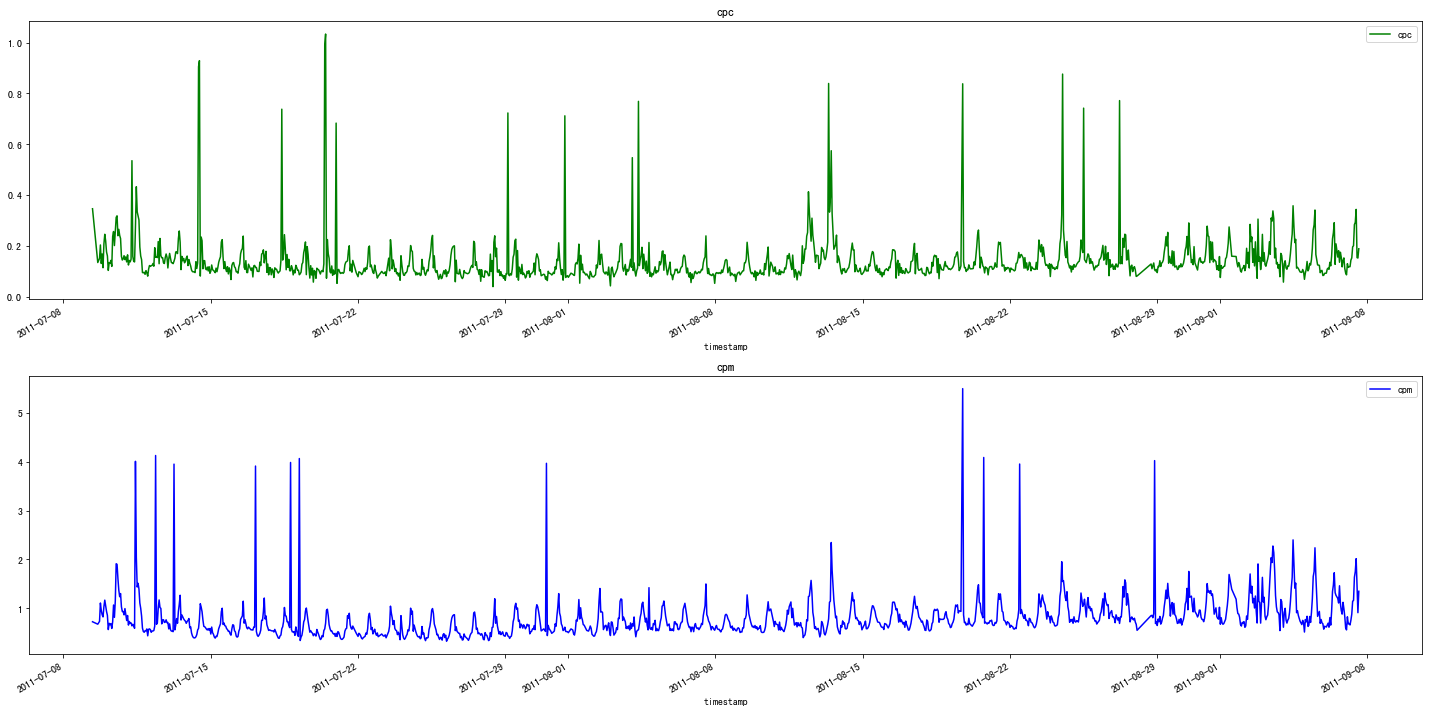

In [9]:
# 按照时间轴绘制 cpc 和 cpm 指标数据
fig, axes = plt.subplots(2, 1)
df.plot(kind='line', x='timestamp', y='cpc', figsize=(20, 10), ax=axes[0], title='cpc', color='g')
df.plot(kind='line', x='timestamp', y='cpm', figsize=(20, 10), ax=axes[1], title='cpm', color='b')
plt.tight_layout();

从上图中可以看出，显然有一些时间点的数据值超出均值非常大，这些点出现十分可疑，应该被检测为异常点。  
目前数据集仅有两个特征，通过热图查看这两个特征之间的相关性。           
通常情况下，通过以下取值范围判断特征的相关强度：               

|相关系数|相关程度|
|--|--|
|0.8-1.0 |极强相关|
|0.6-0.8 |强相关|
|0.4-0.6 |中等程度相关|
|0.2-0.4 |弱相关|
|0.0-0.2 |极弱相关或无相关|

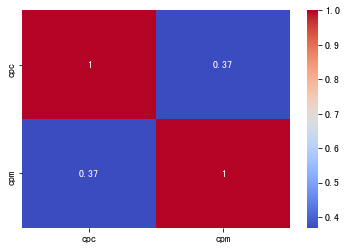

In [10]:
sns.heatmap(df.corr(), cmap='coolwarm', annot=True);

通过热图发现两个特征之间是具有一定的线性相关性，相关程度是弱相关。

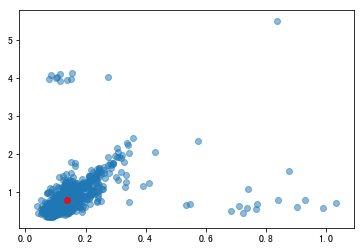

In [11]:
# 绘制 cpc 和 cpm 的散点图，其中横坐标是 cpc，纵坐标是 cpm
plt.scatter(x=df['cpc'],y=df['cpm'],alpha=0.5);
# 绘制数据集中心点，横坐标是 cpc 的平均值，纵坐标是 cpm 的平均值 
plt.scatter(x=df['cpc'].mean(),y=df['cpm'].mean(),c='red',alpha=0.8);

图中红点位置的横坐标是 cpc 的平均值，纵坐标是 cpm 的平均值。                   
在当前特征下，我们将数据聚集于一个聚类中，尝试使用计算当前点（cpc，cpm）到平均值点（cpc_mean，cpm_mean）的几何距离（L2 范数）寻找聚类中的异常点。               
即距离平均值点的距离越大，说明该点是异常点的可能性就越大。

In [12]:
def simple_distance(data):
    """
    计算当前点（cpc，cpm）到（cpc_mean，cpm_mean）的几何距离（L2 范数）
    :param data: ataDFrame 包含cpc、cpm 列
    :return: Series，每一列cpc、cpm到平均值值点的距离大小
    """
    mean = np.array([data['cpc'].mean(), data['cpm'].mean()])
    distance = []
    for i in range(0, len(data)):
        point = np.array(data.iloc[i, 1:3])
        # 求当前点（cpc，cpm）到平均值点（cpc_mean，cpm_mean）之间的几何距离（L2 范数）
        distance.append(np.linalg.norm(point - mean))
    distance = pd.Series(distance)
    return distance

In [13]:
df['distance'] = simple_distance(df[df.columns])
df.head()

,timestamp,cpc,cpm,distance
0,2011-07-09 09:15:01,0.345781,0.722730,0.217999
1,2011-07-09 15:15:01,0.133918,0.672810,0.118490
2,2011-07-09 17:15:01,0.150358,0.730694,0.061596
3,2011-07-09 18:15:01,0.203112,1.106597,0.321885
4,2011-07-09 19:15:01,0.130079,0.951127,0.160166


In [14]:
df.describe()

,cpc,cpm,distance
count,1357.000000,1357.000000,1357.000000
mean,0.138813,0.791199,0.260603
std,0.088819,0.423962,0.345931
min,0.038899,0.323450,0.002440
25%,0.097467,0.566222,0.101204
50%,0.117112,0.697837,0.199706
75%,0.151374,0.892529,0.316918
max,1.034000,5.497540,4.758000


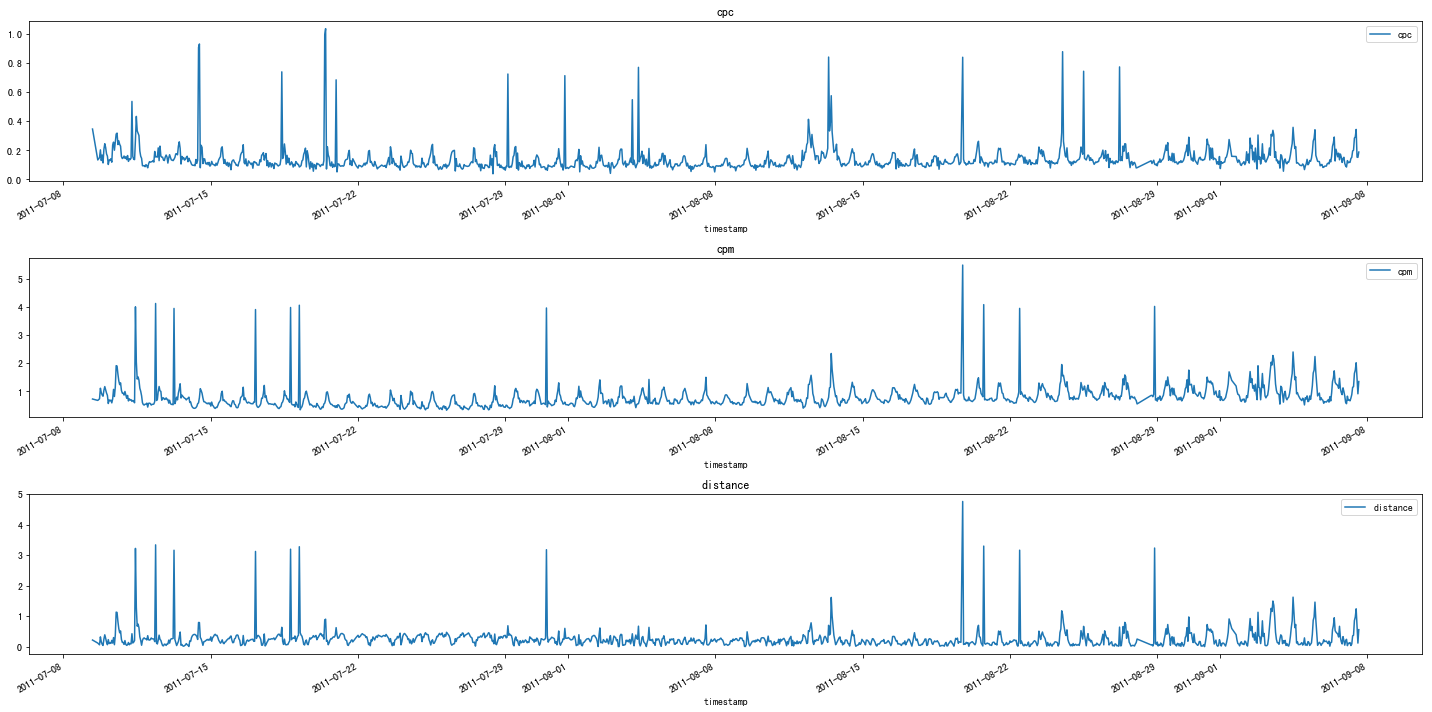

In [15]:
# 按照时间轴绘制 cpc 和 cpm 指标数据
fig,axes = plt.subplots(3,1)
df.plot(kind='line', x = 'timestamp', y = 'cpc',      figsize=(20,10), ax = axes[0], title='cpc')
df.plot(kind='line', x = 'timestamp', y = 'cpm',      figsize=(20,10), ax = axes[1], title='cpm')
df.plot(kind='line', x = 'timestamp', y = 'distance', figsize=(20,10), ax = axes[2], title='distance')
plt.tight_layout()

设置一定的异常点比例（ratio = 0.005），根据距离的大小进行划分，将属于该部分的点设置为异常点。

In [16]:
ratio = 0.005
num_anomaly = int(len(df) * ratio)
threshould = df['distance'].sort_values(ascending=False).reset_index(drop=True)[num_anomaly]
print('阈值距离：' + str(threshould))

阈值距离：3.1940995453298258


In [17]:
df['is_anomaly'] = df['distance'].apply(lambda x: x > threshould)
df.head()

,timestamp,cpc,cpm,distance,is_anomaly
0,2011-07-09 09:15:01,0.345781,0.722730,0.217999,False
1,2011-07-09 15:15:01,0.133918,0.672810,0.118490,False
2,2011-07-09 17:15:01,0.150358,0.730694,0.061596,False
3,2011-07-09 18:15:01,0.203112,1.106597,0.321885,False
4,2011-07-09 19:15:01,0.130079,0.951127,0.160166,False


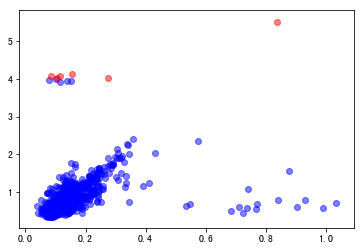

In [18]:
normal = df[df['is_anomaly'] == 0]
anormal = df[df['is_anomaly'] == 1]
plt.scatter(x = normal['cpc'], y = normal['cpm'], c = 'blue', alpha = 0.5)
plt.scatter(x = anormal['cpc'],y = anormal['cpm'],c = 'red', alpha=0.5);

我们发现直观的方法并不合适，右下角像异常点的数据并没有被分类为异常点，原因可能是两个特征分布的区间并不相同；                   
`cpm` 特征分布在更大的范围内，因此在寻找异常点之前进行数据标准化，使用`sklearn`中的标准化函数，数据标准化后分布在（-1，1）之间。              
标准化公式：                  
<center><img src="https://imgbed.momodel.cn/20210127103938.png"/>
    
其中 μ 为所有样本数据的均值，σ 为所有样本数据的标准差。

In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[['cpc','cpm']] = scaler.fit_transform(df[['cpc','cpm']])
df.describe()

,cpc,cpm,distance
count,1.357000e+03,1.357000e+03,1357.000000
mean,3.141678e-17,-2.094452e-16,0.260603
std,1.000369e+00,1.000369e+00,0.345931
min,-1.125338e+00,-1.103686e+00,0.002440
25%,-4.656857e-01,-5.308498e-01,0.101204
50%,-2.444261e-01,-2.202947e-01,0.199706
75%,1.414686e-01,2.390963e-01,0.316918
max,1.008249e+01,1.110495e+01,4.758000


阈值距离：7.888834917796643


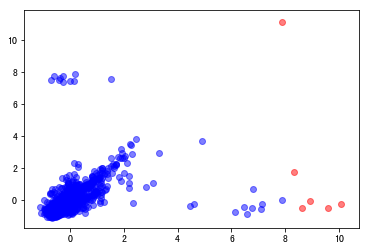

In [20]:
# 假设异常数据比例
ratio = 0.005
num_anomaly = int(len(df) * ratio)
df['distance2'] = simple_distance(df)
threshould = df['distance2'].sort_values(ascending=False).reset_index(drop=True)[num_anomaly]
print('阈值距离：'+str(threshould))
df['is_anomaly2'] = df['distance2'].apply(lambda x: x > threshould)
normal = df[df['is_anomaly2'] == 0]
anormal = df[df['is_anomaly2'] == 1]
plt.scatter(x=normal['cpc'],y=normal['cpm'],c='blue',alpha=0.5)
plt.scatter(x=anormal['cpc'],y=anormal['cpm'],c='red',alpha=0.5);

从时间维度查看被检测为异常点的数据点，从下图可以发现某些明显高过均值的点已经被标记为异常点

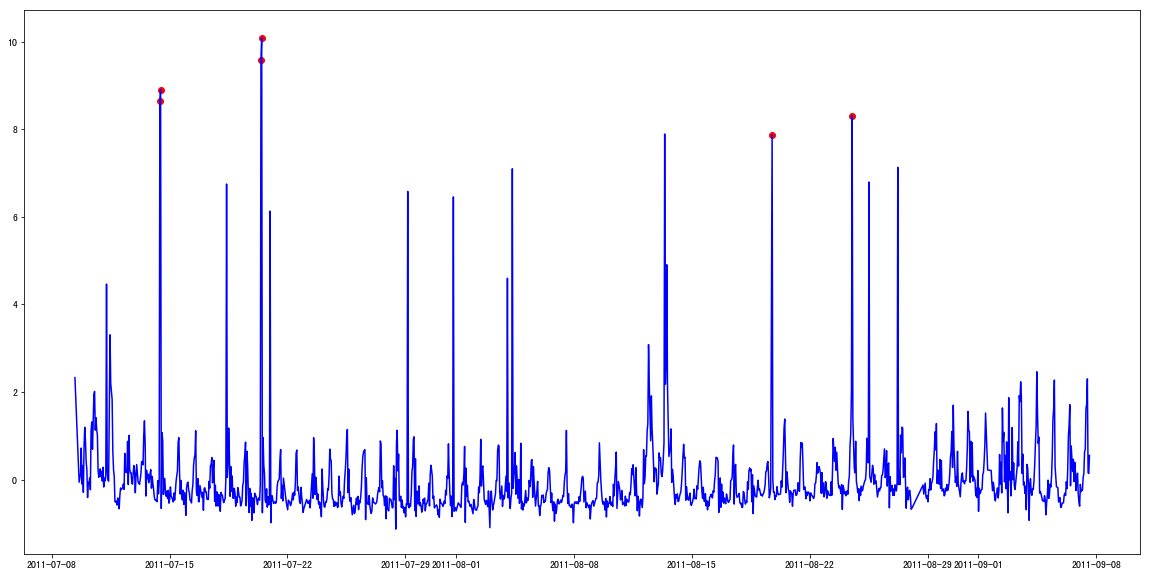

In [21]:
a = df.loc[df['is_anomaly2'] == 1, ['timestamp', 'cpc']] 
plt.figure(figsize=(20,10))
plt.plot(df['timestamp'], df['cpc'], color='blue')
plt.scatter(a['timestamp'],a['cpc'], color='red')
plt.show()

通过上述的流程我们似乎已经比较好的解决了问题，但是由于数据集比较简单，解决方案存在一些**问题**：

- 当前的数据特征为 2 维，我们容易可视化特征，可以观察到数据是一个聚类，可以计算数据的中心点，但当数据的特征数量大于3，无法有效的可视化，无法得知当前分布情况是否是一个簇？
- 只使用一个簇来衡量数据集是否是合理的？如果确实存在其他潜在的隐藏变量左右了可以观测到的特征的联合分布，存在一个远离大多点的簇是合理的，例如我们数据中右下角的簇，只使用一个簇划分数据有时可能会损失重要的信息。

### 2.3 特征构造与 PCA  
在上面的简单例子中，我们仅仅使用到了 2 个特征，接下来我们将构造一些额外的特征，进一步用于探究异常点检测。  
- 对于目前存在的 2 个特征可以尝试引入他们的线性、非线性组合作为新的特征，在构建特征的过程中往往需要具体考虑特征所代表的意义，需要相关方面的专业知识。
- 同时考虑到异常出现的位置，其往往可能与时间点有关，可能每一次产生异常点的时间段总是集中在某一个时间点，或者在更大的粒度上，可能异常总是出现在白天或者晚上，因此向原来的数据集中添加有关时间信息的特征，可以提供额外的时间信息，帮助算法寻找异常点在空间维度上的信息。

In [22]:
# 尝试引入非线性关系
df['cpc X cpm'] = df['cpm'] * df['cpc']
df['cpc / cpm'] = df['cpc'] / df['cpm']

In [23]:
# 尝试获取时间关系
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)

In [24]:
df1 = df[['cpc','cpm','cpc X cpm','cpc / cpm','hours','daylight']]
df1.corr()

,cpc,cpm,cpc X cpm,cpc / cpm,hours,daylight
cpc,1.000000,3.687357e-01,0.280616,-9.982535e-02,-0.002698,0.204379
cpm,0.368736,1.000000e+00,0.400464,1.760450e-17,0.104674,0.258816
cpc X cpm,0.280616,4.004645e-01,1.000000,3.121360e-03,0.018740,0.057734
cpc / cpm,-0.099825,1.760450e-17,0.003121,1.000000e+00,0.012513,0.021875
hours,-0.002698,1.046745e-01,0.018740,1.251308e-02,1.000000,0.603309
daylight,0.204379,2.588164e-01,0.057734,2.187479e-02,0.603309,1.000000


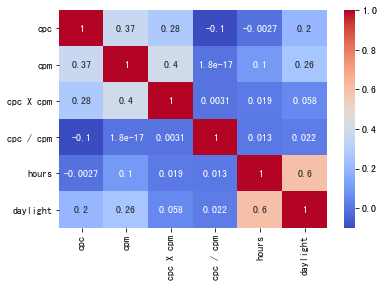

In [25]:
sns.heatmap(df1.corr(),cmap='coolwarm',annot=True);

从上图中可以看出，`daylight` 与 `cpc`、`cpm` 仍然具有一定的相关性，说明时间是白天还是晚上对于广告的点击量具有一定的影响。  
  
加上 `cpc X cpm`、`cpc / cpm`、`hours`、`daylight` 等特征之后，数据的特征数量就大于 3，无法观察数据的分布以及分多少个簇合适等；                                    
而且以上各个特征之间并不是相互独立的，存在一定程度上的相关性；故我们采用 PCA (主成分分析)来寻找数据集的低维度表达。                          
PCA 通过对数据特征的变换，寻找特征空间中，数据分布方差最大的方向，称为特征方向或主成分方向，选择其中特征值较大的几个特征方向，将数据点投影到这些方向上，完成数据降维。                

可以参考以下这三篇文章：
- https://zhuanlan.zhihu.com/p/77151308
- https://www.zhihu.com/question/41120789?sort=created
- https://www.cs.princeton.edu/picasso/mats/PCA-Tutorial-Intuition_jp.pdf

使用 `sklearn` 包中的 `PCA` 方法可以方便的进行特征降维。

In [26]:
from sklearn.decomposition import PCA

#在进行特征变换之前先对各个特征进行标准化
columns = ['cpc', 'cpm', 'cpc X cpm', 'cpc / cpm']
data = df[columns]
scaler = StandardScaler()
data = scaler.fit_transform(data)
data = pd.DataFrame(data, columns=columns)

#通过 n_components 指定需要降低到的维度
n_components = 3
pca = PCA(n_components=n_components)
data = pca.fit_transform(data)
data = pd.DataFrame(data,columns=['Dimension' + str(i+1) for i in range(n_components)])
data.head()

,Dimension1,Dimension2,Dimension3
0,1.057402,-0.831550,-1.780333
1,-0.273861,-0.081118,-0.045960
2,-0.093814,-0.123222,-0.178103
3,0.891074,-0.041173,-0.456766
4,0.091373,-0.005642,-0.007222


在 `PCA` 对象中存储了数据降维过程中的信息，包括特征方向，各个投影方向上的方差等等

In [27]:
# 特征变换空间（特征矩阵），根据我们指定的n_components = k的值，选择方差最大的 k 个值所对应的的特征向量组成的特征矩阵。
print(pd.DataFrame(pca.components_, columns=['Dimension' + str(i + 1) for i in range(pca.n_features_)]))

   Dimension1  Dimension2  Dimension3  Dimension4
0    0.552669    0.608565    0.564346   -0.075625
1   -0.176006    0.123717    0.167871    0.962047
2   -0.722361    0.027153    0.644877   -0.248174


In [28]:
# 每个保留特征占所有特征的方差百分比
pca.explained_variance_ratio_

array([0.42655847, 0.25470191, 0.17533196])

In [29]:
# 保留 n 个特征的方差
pca.explained_variance_

array([1.70749217, 1.01955898, 0.70184503])

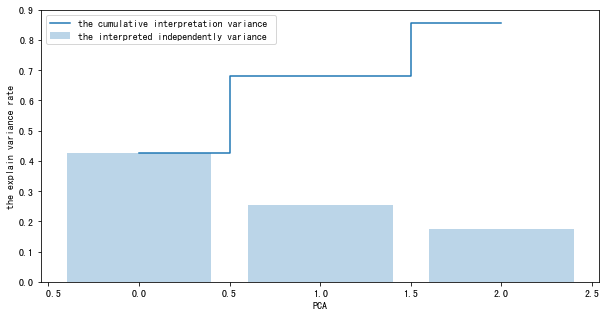

In [30]:
var_explain = pca.explained_variance_ratio_
# 梯形累计和，axis=0，按照行累加。axis=1，按照列累加。axis不给定具体值，就把数组当成一个一维数组
cum_var_explian = np.cumsum(var_explain)

plt.figure(figsize=(10, 5))
plt.bar(range(len(var_explain)), var_explain, alpha=0.3, align='center', label='the interpreted independently variance ')
plt.step(range(len(cum_var_explian)), cum_var_explian, where='mid', label='the cumulative interpretation variance')
plt.ylabel('the explain variance rate')
plt.xlabel('PCA')
plt.legend(loc='best')
plt.show()

可以看到，原数据集的特征经过一些列的数据处理后，特征维数变多；                 
而我们认知（比较容易理解）的图形主要有二维平面几何图形和三维立体图形；           
特征经过 PCA 处理后的 3 个特征就可以表达原数据 80% 以上的数据信息；             
因此用这新的 3 个特征就可以较好的表达原数据，那么我们看看这 3 个新特征的数据信息：     

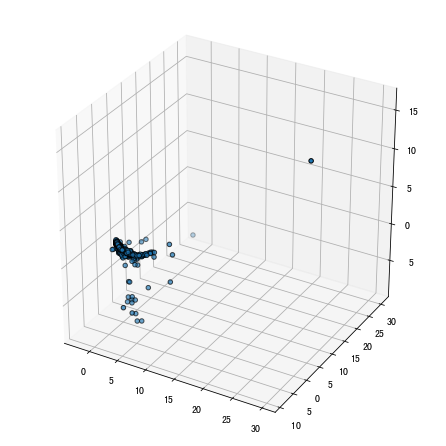

In [31]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1,figsize=(6,6))
ax = Axes3D(fig)
ax.scatter(data.iloc[:,0],data.iloc[:,1],data.iloc[:,2],edgecolors='k');

### 2.4  KMeans  聚类与异常检测 
从上图中可以看出，数据的分布并不只有一个簇，在寻找异常点时候，应该首先将所有数据点分为多个簇，再计算各个簇中显著远离簇中心的点，作为数据中的异常点。  



#### 2.4.1 KMeans 算法介绍
KMeans 算法的思想很简单，按照样本之间的距离大小，将样本集划分为 K 个簇。                   
让簇内的点尽量紧密的连在一起，而让簇间的距离尽量的大。            
我们使用 KMeans 聚类方法完成检测，在 Kmeans 方法中，每个数据点具有两个属性：           
 - 该点所属的簇            
 - 该点与各个簇中心点的距离


我们希望每一个点找到距离自己最近的簇，而且不同簇之间距离尽量大。因此出现了 KMeans 的分步优化的方法：
 - 第一步根据当前各个簇中心，计算每个数据点与各个簇中心的距离，将该点划分为距离簇中心最近的簇类别；
 - 第二步根据重新划分的簇，更新每个簇的中心位置。直至簇中心不再变化时停止优化。

参考资料：
 - https://zhuanlan.zhihu.com/p/20432322
 - https://www.cnblogs.com/pinard/p/6169370.html

In [97]:
class KMeans():
    """
    Parameters
    ----------
    n_clusters 指定了需要聚类的个数，这个超参数需要自己调整，会影响聚类的效果
    n_init 指定计算次数，算法并不会运行一遍后就返回结果，而是运行多次后返回最好的一次结果，n_init即指明运行的次数
    max_iter 指定单次运行中最大的迭代次数，超过当前迭代次数即停止运行
    """
    def __init__(
                self,
                n_clusters=8,
                n_init=10,
                max_iter=300
                ):

        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.n_init = n_init


    def fit(self, x):
        """
        用fit方法对数据进行聚类
        :param x: 输入数据
        :best_centers: 簇中心点坐标 数据类型: ndarray
        :best_labels: 聚类标签 数据类型: ndarray
        :best_inertia: 最优的损失函数值 数据类型: float
        :return: self
        """
        ###################################################################################
        #### 请勿修改该函数的输入输出 ####
        ###################################################################################
        # #

        # #
        ###################################################################################
        ############# 在生成 main 文件时, 请勾选该模块 ############# 
        ###################################################################################
        best_centers = None
        best_labels = None
        best_inertia = None

        for i in range(self.n_init):
            # 初始化簇中心: random / k-means++
            init_centers = np.zeros((self.n_clusters, x.shape[1]))
            x_array = x.to_numpy()
#             random_indexes = random.sample(range(len(x)), self.n_clusters)
#             for i in range(self.n_clusters):
#                 init_centers[i] = x_array[random_indexes[i]]
            init_centers[0] = x_array[random.randint(0, len(x))]
            for i in range(1, self.n_clusters):
                distances = []
                for e in x_array:
                    min_distance_squared = np.inf  # 初始设为无穷大
                    for center in init_centers[:i]:
                        distance_squared = np.linalg.norm(e - center) ** 2
                        min_distance_squared = min(min_distance_squared, distance_squared)
                    distances.append(min_distance_squared)
                distances = np.array(distances)
                probabilities = distances / np.sum(distances)
                chosen_index = self.roulette_selection(probabilities)
                init_centers[i] = x_array[chosen_index]    
            # 运行单次k-means算法
            centers, labels, inertia = self.kmeans(x, init_centers)
            # 选择最优结果保存
            if best_inertia is None or inertia < best_inertia:
                best_inertia = inertia
                best_centers = centers
                best_labels = labels
        self.cluster_centers_ = best_centers
        self.labels_ = best_labels
        return self
    
    def roulette_selection(self, weights):
        total_weight = sum(weights)
        threshold = np.random.uniform(0, total_weight)
        cumulative_weight = 0
        for i, weight in enumerate(weights):
            cumulative_weight += weight
            if cumulative_weight > threshold:
                return i

    def kmeans(self, x, init_centers):
        """
        用kmeans方法对数据进行聚类
        :param x: 输入数据
        :param init_centers: 初始化的簇中心
        :return: centers: 簇中心点坐标 数据类型: ndarray
        :return: labels: 聚类标签 数据类型: ndarray
        :return: inertia: 损失函数值 数据类型: float
        """
        centers = init_centers
        labels = np.zeros(len(x))
        for i in range(self.max_iter):
            # 计算每个样本点到簇中心的距禶
            distance = []
            for center in centers:
                distance.append(np.linalg.norm(x - center, axis=1))
            distance = np.array(distance).T
            # 更新每个样本点的簇标签
            new_labels = np.argmin(distance, axis=1)
            # 判断是否收敛
            if np.array_equal(labels, new_labels):
                break
            labels = new_labels
            # 更新簇中心
            for i in range(self.n_clusters):
                centers[i] = np.mean(x[labels == i], axis=0)
        inertia = 0
        for i in range(self.n_clusters):
            inertia += np.sum(np.linalg.norm(x[labels == i] - centers[i], axis=1) ** 2)
        return centers, labels, inertia

In [98]:
kmeans = KMeans(n_clusters=5, n_init=50, max_iter=800)
kmeans.fit(data)

TypeError: roulette_selection() takes 1 positional argument but 2 were given

在 KMeans 对象中存放了数据中心点，数据点所属聚类等运行结果信息。

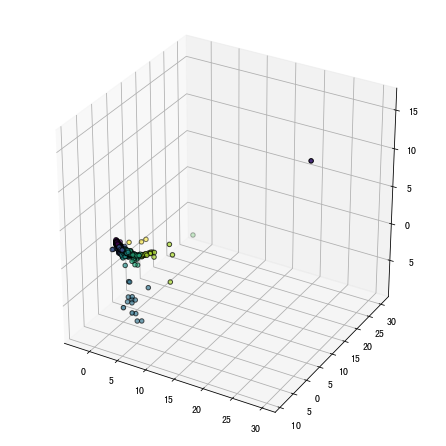

In [81]:
labels = pd.Series(kmeans.labels_)
fig = plt.figure(1,figsize=(6,6))
ax = Axes3D(fig)
ax.scatter(data.iloc[:,0],data.iloc[:,1],data.iloc[:,2],c=labels.astype('float'),edgecolors='k');

#### 2.4.2 聚类评价指标

对于当前产生的聚类，由于缺失标签，我们可以使用一些其他的方式对聚类效果进行评分，一般有 `calinski_harabasz_score`、`silhouette_score` 两种评价方式。

`calinski_harabasz_score`：通过计算簇中各点与簇中心的距离平方和来度量簇内的紧密度，通过计算各簇中心点与数据集中心点距离平方和来度量数据集的分离度，由分离度与紧密度的比值得到。即该指标越大代表着簇自身越紧密，簇与簇之间越分散，即聚类结果越好。

`silhouette_score`(轮廓系数)结合了凝聚度和分离度，其计算步骤如下：
- 对于第 i 个对象，计算它到所属簇中所有其他对象的平均距离，记 ai （体现凝聚度）
- 对于第 i 个对象和不包含该对象的任意簇，计算该对象到给定簇中所有对象的平均距离，记 bi （体现分离度）
- 第 i 个对象的轮廓系数为 si = (bi-ai)/max(ai, bi)  

从上面可以看出，轮廓系数取值为 [-1, 1]，其值越大越好，且当值为负时，表明 ai < bi，样本被分配到错误的簇中，聚类结果不可接受。对于接近 0 的结果，则表明聚类结果有重叠的情况。

参考资料：
- https://medium.com/@haataa/how-to-measure-clustering-performances-when-there-are-no-ground-truth-db027e9a871c
- https://scikit-learn.org/stable/modules/clustering.html#clustering-evaluation
- https://blog.csdn.net/u012967763/article/details/79149703

In [82]:
from sklearn.metrics import calinski_harabasz_score,silhouette_score

score1 = calinski_harabasz_score(data,kmeans.labels_)
score2 = silhouette_score(data,kmeans.labels_)

print('calinski_harabasz_score:', score1)
print('silhouette_score:', score2)

calinski_harabasz_score: 2036.525274727285
silhouette_score: 0.45396868915162564


In [83]:
# 寻找最佳聚类数目
from sklearn.metrics import calinski_harabasz_score,silhouette_score

'''
n_clusters 指定了需要聚类的个数，这个超参数需要自己调整，会影响聚类的效果
init 指明初始聚类中心点的初始化方式，kmeans++是一种初始化方式，还可以选择为random
n_init 指定计算次数，算法并不会运行一遍后就返回结果，而是运行多次后返回最好的一次结果，n_init即指明运行的次数
max_iter 指定单次运行中最大的迭代次数，超过当前迭代次数即停止运行
'''
score1_list = []
score2_list = []
for i in range(2,10):
    kmeans = KMeans(n_clusters=i,n_init=10,max_iter=100)
    kmeans.fit(data)
    score1 = round(calinski_harabasz_score(data,kmeans.labels_), 2)
    score2 = round(silhouette_score(data,kmeans.labels_), 2)
    score1_list.append(score1)
    score2_list.append(score2)
    print('聚类数目:%s  calinski_harabasz_score:%-10s  silhouette_score:%-10s'%(i,score1,score2))

聚类数目:2  calinski_harabasz_score:459.37      silhouette_score:0.79      
聚类数目:3  calinski_harabasz_score:547.69      silhouette_score:0.75      
聚类数目:4  calinski_harabasz_score:534.16      silhouette_score:0.67      
聚类数目:5  calinski_harabasz_score:598.82      silhouette_score:0.58      
聚类数目:6  calinski_harabasz_score:1282.6      silhouette_score:0.58      
聚类数目:7  calinski_harabasz_score:1248.77     silhouette_score:0.49      
聚类数目:8  calinski_harabasz_score:1179.71     silhouette_score:0.45      
聚类数目:9  calinski_harabasz_score:1110.75     silhouette_score:0.42      


计算各个样本点到中心的距离用于判断样本点是否为异常点

In [84]:
def get_distance(data, kmeans, n_features):
    """
    计算距离函数
    :param data: 训练 kmeans 模型的数据
    :param kmeans: 训练好的 kmeans 模型
    :param n_features: 计算距离需要的特征的数量
    :return: 每个点距离自己簇中心的距离
    """
    distance = []
    for i in range(0,len(data)):
        point = np.array(data.iloc[i,:n_features])
        center = kmeans.cluster_centers_[kmeans.labels_[i],:n_features]
        distance.append(np.linalg.norm(point - center))
    distance = pd.Series(distance)
    return distance

In [85]:
from copy import deepcopy
ratio = 0.01
num_anomaly = int(len(data) * ratio)
new_data = deepcopy(data)
new_data['distance'] = get_distance(new_data,kmeans,n_features=len(new_data.columns))
threshould = new_data['distance'].sort_values(ascending=False).reset_index(drop=True)[num_anomaly]
print('阈值距离：'+str(threshould))

阈值距离：2.670224282153338


In [86]:
# 根据阈值距离大小判断每个点是否是异常值
new_data['is_anomaly'] = new_data['distance'].apply(lambda x: x > threshould)
normal = new_data[new_data['is_anomaly'] == 0]
anormal = new_data[new_data['is_anomaly'] == 1]
new_data.head()

,Dimension1,Dimension2,Dimension3,distance,is_anomaly
0,1.057402,-0.831550,-1.780333,1.554550,False
1,-0.273861,-0.081118,-0.045960,0.117215,False
2,-0.093814,-0.123222,-0.178103,0.324461,False
3,0.891074,-0.041173,-0.456766,0.237467,False
4,0.091373,-0.005642,-0.007222,0.275818,False


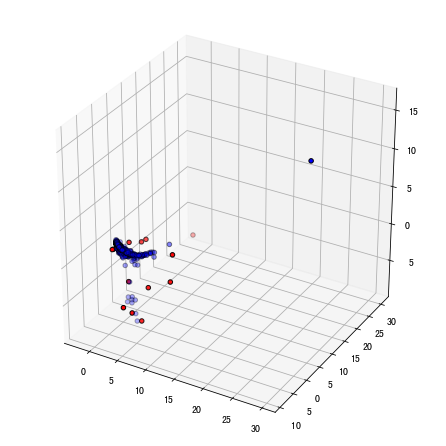

In [87]:
fig = plt.figure(1, figsize=(6, 6))
ax = Axes3D(fig)
ax.scatter(anormal.iloc[:, 0], anormal.iloc[:, 1], anormal.iloc[:, 2], c='red', edgecolors='k')
ax.scatter(normal.iloc[:, 0], normal.iloc[:, 1], normal.iloc[:, 2], c='blue', edgecolors='k');

#### 2.4.3 保存模型

大家尽量将模型保存在 `results` 文件夹中。

In [88]:
#保存模型，用于后续的测试打分
from sklearn.externals import joblib
joblib.dump(kmeans, './results/model_3.pkl')
joblib.dump(scaler, './results/scaler_3.pkl')
joblib.dump(pca, './results/pca_3.pkl')

['./results/pca_3.pkl']

通过可视化观察模型的性能，由于超参数并未仔细调整，模型能力并不强，请同学们继续调整优化模型，达到更好的效果。

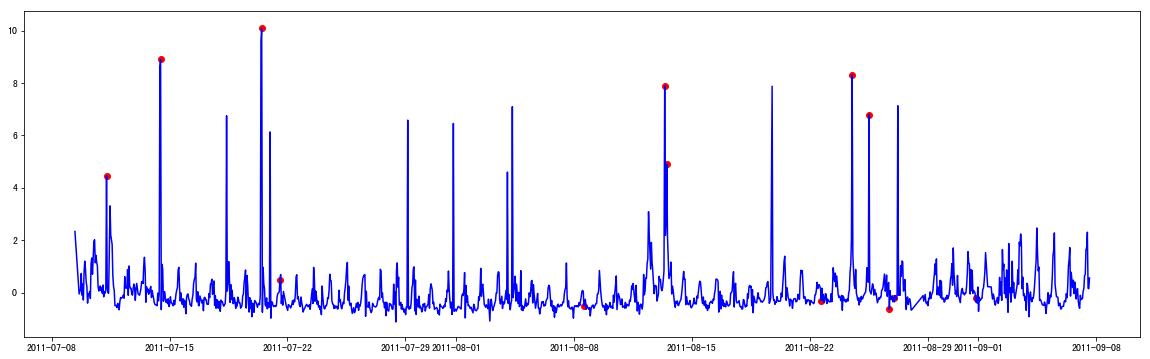

In [89]:
a = df.loc[new_data['is_anomaly'] == 1, ['timestamp', 'cpc']] 
plt.figure(figsize=(20,6))
plt.plot(df['timestamp'], df['cpc'], color='blue')
# 聚类后 cpc 的异常点
plt.scatter(a['timestamp'],a['cpc'], color='red')
plt.show()

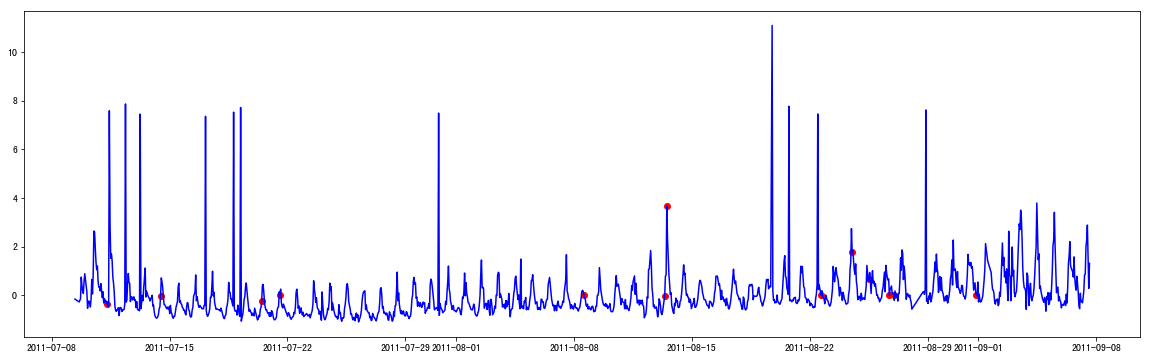

In [90]:
a = df.loc[new_data['is_anomaly'] == 1, ['timestamp', 'cpm']] 
plt.figure(figsize=(20,6))
plt.plot(df['timestamp'], df['cpm'], color='blue')
# 聚类后 cpm 的异常点
plt.scatter(a['timestamp'],a['cpm'], color='red')
plt.show()

# 3.测试提交

通过对以上步骤流程的了解，相信大家对 KMeans 算法进行异常检测有了深入的认识，但是各个参数并没有被调整到最佳状态，效果并不好，大家可以尝试构造更多特征使模型获得更强的能力。           
在训练模型等过程中如果需要 **保存数据、模型**等请保存到 **results** 文件夹 

**测试提交时请注意**：

1. 请完成 `preprocess_data`、`get_distance`、`get_anomaly` 函数的相关改进，调整超参数，并完成训练。
2. 测试提交时请导入必要的包和第三方库 (包括此文件中曾经导入过的)。
3. 点击左侧栏`提交结果`后点击`生成文件`则需勾选 `preprocess_data()`、`get_distance()`、`get_anomaly()` 和 `predict()`函数及导入相关包的 cell， 转化为 py 文件后进行`系统测试`，测试通过后即可提交。
4. 请加载你认为训练最佳的模型，即请按要求填写模型路径。          
5. **测试提交时服务端会调用 `preprocess_data()`、`get_distance()`、`get_anomaly()` 和 `predict()`函数，请不要修改该函数的输入输出及其数据类型。**     
6. 测试提交时记得填写你的模型路径及名称, 如果采用 [离线任务](https://momodel.cn/docs/#/zh-cn/%E5%9C%A8GPU%E6%88%96CPU%E8%B5%84%E6%BA%90%E4%B8%8A%E8%AE%AD%E7%BB%83%E6%9C%BA%E5%99%A8%E5%AD%A6%E4%B9%A0%E6%A8%A1%E5%9E%8B) 请将模型保存在 **results** 文件夹下。

==================================  **答题区域，请勿在别的位置作答**  =================================
<br>

大家可以实现自己的 `preprocess_data`、`get_distance`、`get_anomaly`、`Kmeans`和 `predict` 等类和函数，请在下面的 `cell` 中按要求完成用于测试提交的函数内容。

注意: 请各位同学将自己撰写的Kmeans算法(仅贴代码即可)贴到实验报告里进行提交. 

In [ ]:
import os
import sklearn
import warnings
import random
import numpy as np
import pandas as pd
import seaborn as sns
from copy import deepcopy
from sklearn.externals import joblib
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

def preprocess_data(df):
    """
    数据处理及特征工程等
    :param df: 读取原始 csv 数据，有 timestamp、cpc、cpm 共 3 列特征
    :return: 处理后的数据, 返回 pca 降维后的特征
    """
    # 请使用joblib函数加载自己训练的 scaler、pca 模型，方便在测试时系统对数据进行相同的变换
    # ====================数据预处理、构造特征等========================
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['hours'] = df['timestamp'].dt.hour
    df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)
    # 尝试引入非线性关系
    df['cpc X cpm'] = df['cpm'] * df['cpc']
    df['cpc / cpm'] = df['cpc'] / df['cpm']

    # ========================  模型加载  ===========================
    columns = ['cpc', 'cpm', 'cpc X cpm', 'cpc / cpm', 'hours', 'daylight']
    scaler = joblib.load('./results/scaler_3.pkl')
    pca = joblib.load('./results/pca_3.pkl')
    data = df[columns]
    data = scaler.fit_transform(data)
    data = pca.fit_transform(data)
    data = pd.DataFrame(data,columns=['Dimension' + str(i+1) for i in range(pca.n_components)])
    return data

In [ ]:
def get_distance(data, kmeans, n_features):
    """
    计算样本点与聚类中心的距离
    :param data: preprocess_data 函数返回值，即 pca 降维后的数据
    :param kmeans: 通过 joblib 加载的模型对象，或者训练好的 kmeans 模型
    :param n_features: 计算距离需要的特征的数量
    :return:每个点距离自己簇中心的距离，Series 类型
    """
    # ====================计算样本点与聚类中心的距离========================
    distance = []
    for i in range(0,len(data)):
        point = np.array(data.iloc[i,:n_features])
        center = kmeans.cluster_centers_[kmeans.labels_[i],:n_features]
        distance.append(np.linalg.norm(point - center))
    distance = pd.Series(distance)
    return distance
    

In [ ]:
def get_anomaly(data, kmean, ratio):
    """
    检验出样本中的异常点，并标记为 True 和 False，True 表示是异常点

    :param data: preprocess_data 函数返回值，即 pca 降维后的数据，DataFrame 类型
    :param kmean: 通过 joblib 加载的模型对象，或者训练好的 kmeans 模型
    :param ratio: 异常数据占全部数据的百分比,在 0 - 1 之间，float 类型
    :return: data 添加 is_anomaly 列，该列数据是根据阈值距离大小判断每个点是否是异常值，元素值为 False 和 True
    """
    # ====================检验出样本中的异常点========================
    num_anomaly = int(len(data) * ratio)
    new_data = deepcopy(data)
    new_data['distance'] = get_distance(new_data, kmean, n_features=len(new_data.columns))
    threshould = new_data['distance'].sort_values(ascending=False).reset_index(drop=True)[num_anomaly]
    is_anomaly = new_data['distance'].apply(lambda x: x > threshould)
    data['is_anomaly'] = is_anomaly
    return data

请在 `predict` 函数中按照给出的提示返回相关的数据用于最后的测试以及评分，测试将主要调用 `predict` 函数，请务必保证 `predict` 调用的相关函数已经被正确填写。

In [ ]:
def predict(preprocess_data):
    """
    该函数将被用于测试，请不要修改函数的输入输出，并按照自己的模型返回相关的数据。
    在函数内部加载 kmeans 模型并使用 get_anomaly 得到每个样本点异常值的判断
    :param preprocess_data: preprocess_data函数的返回值，一般是 DataFrame 类型
    :return:is_anomaly:get_anomaly函数的返回值，各个属性应该为（Dimesion1,Dimension2,......数量取决于具体的pca），distance,is_anomaly，请确保这些列存在
            preprocess_data:  即直接返回输入的数据
            kmeans: 通过joblib加载的对象
            ratio:  异常点的比例，ratio <= 0.03   返回非异常点得分将受到惩罚！
    """
    data = deepcopy(preprocess_data)
    # 异常值所占比率
    ratio = 0.03
    # 加载模型 
    kmeans = joblib.load('./results/model_3.pkl')
    # 获取异常点数据信息
    is_anomaly = get_anomaly(data, kmeans, ratio)
    
    return is_anomaly, preprocess_data, kmeans, ratio

以上就是 KMeans 实现异常检测的过程，祝愿大家学有所获、取得优异的成绩！！！
